# Object Detection and Bounding Boxes


In image classification tasks,
we assume that there is only *one*
major object
in the image and we only focus on how to 
recognize its category.
However, there are often *multiple* objects
in the image of interest.
We not only want to know their categories, but also their specific positions in the image.
In computer vision, we refer to such tasks as *object detection* (or *object recognition*).

Object detection has been
widely applied in many fields.
For example, self-driving needs to plan 
traveling routes
by detecting the positions
of vehicles, pedestrians, roads, and obstacles in the captured video images.
Besides,
robots may use this technique
to detect and localize objects of interest
throughout its navigation of an environment.
Moreover,
security systems
may need to detect abnormal objects, such as intruders or bombs.

In the next few sections, we will introduce 
several deep learning methods for object detection.
We will begin with an introduction
to *positions* (or *locations*) of objects.


In [16]:
%matplotlib inline
import torch
import matplotlib.pyplot as plt
import numpy as np

We will load the sample image to be used in this section. We can see that there is a dog on the left side of the image and a cat on the right.
They are the two major objects in this image.


--2023-10-25 16:10:59--  https://raw.githubusercontent.com/d2l-ai/d2l-en/master/img/catdog.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 32576 (32K) [image/jpeg]
Saving to: ‘catdog.jpg’

catdog.jpg          100%[===================>]  31.81K  --.-KB/s    in 0.004s  

2023-10-25 16:10:59 (7.70 MB/s) - ‘catdog.jpg’ saved [32576/32576]



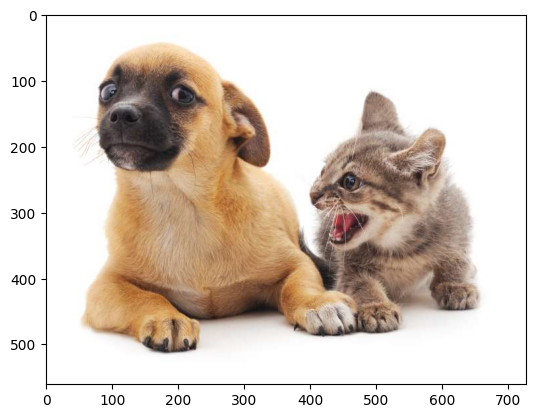

In [2]:
!test -f catdog.jpg || wget https://raw.githubusercontent.com/d2l-ai/d2l-en/master/img/catdog.jpg
img = plt.imread('catdog.jpg')
plt.imshow(img);

## Bounding Boxes


In object detection,
we usually use a *bounding box* to describe the spatial location of an object.
The bounding box is rectangular, which is determined by the $x$ and $y$ coordinates of the upper-left corner of the rectangle and the such coordinates of the lower-right corner. 
Another commonly used bounding box representation is the $(x, y)$-axis
coordinates of the bounding box center, and the width and height of the box.

**Here we define functions to convert between** these (**two
representations**):
`box_corner_to_center` converts from the two-corner
representation to the center-width-height presentation,
and `box_center_to_corner` vice versa.
The input argument `boxes` should be a two-dimensional tensor of
shape ($n$, 4), where $n$ is the number of bounding boxes.


In [3]:
def box_corner_to_center(boxes):
    """Convert from (upper-left, lower-right) to (center, width, height)."""
    x1, y1, x2, y2 = boxes[:, 0], boxes[:, 1], boxes[:, 2], boxes[:, 3]
    cx = (x1 + x2) / 2
    cy = (y1 + y2) / 2
    w = x2 - x1
    h = y2 - y1
    boxes = torch.stack((cx, cy, w, h), axis=-1)
    return boxes

def box_center_to_corner(boxes):
    """Convert from (center, width, height) to (upper-left, lower-right)."""
    cx, cy, w, h = boxes[:, 0], boxes[:, 1], boxes[:, 2], boxes[:, 3]
    x1 = cx - 0.5 * w
    y1 = cy - 0.5 * h
    x2 = cx + 0.5 * w
    y2 = cy + 0.5 * h
    boxes = torch.stack((x1, y1, x2, y2), axis=-1)
    return boxes

We will **define the bounding boxes of the dog and the cat in the image** based
on the coordinate information.
The origin of the coordinates in the image
is the upper-left corner of the image, and to the right and down are the
positive directions of the $x$ and $y$ axes, respectively.


In [4]:
# Here `bbox` is the abbreviation for bounding box
dog_bbox, cat_bbox = [60.0, 45.0, 378.0, 516.0], [400.0, 112.0, 655.0, 493.0]

We can verify the correctness of the two
bounding box conversion functions by converting twice.


In [5]:
boxes = torch.tensor((dog_bbox, cat_bbox))
box_center_to_corner(box_corner_to_center(boxes)) == boxes

tensor([[True, True, True, True],
        [True, True, True, True]])

Let's **draw the bounding boxes in the image** to check if they are accurate.
Before drawing, we will define a helper function `bbox_to_rect`. It represents the bounding box in the bounding box format of the  `matplotlib` package.


In [6]:
#@save
def bbox_to_rect(bbox, color):
    """Convert bounding box to matplotlib format."""
    # Convert the bounding box (upper-left x, upper-left y, lower-right x,
    # lower-right y) format to the matplotlib format: ((upper-left x,
    # upper-left y), width, height)
    return plt.Rectangle(
        xy=(bbox[0], bbox[1]), width=bbox[2]-bbox[0], height=bbox[3]-bbox[1],
        fill=False, edgecolor=color, linewidth=2)

After adding the bounding boxes on the image,
we can see that the main outline of the two objects are basically inside the two boxes.


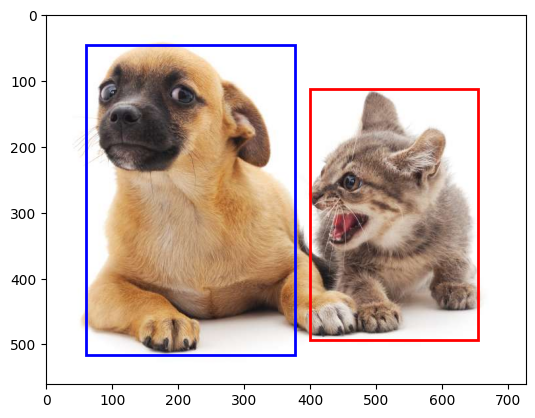

In [7]:
fig = plt.imshow(img)
fig.axes.add_patch(bbox_to_rect(dog_bbox, 'blue'))
fig.axes.add_patch(bbox_to_rect(cat_bbox, 'red'));

### Your turn
> Here is a new image below: display it and create the bounding boxes for some of the Pikachus it contains, then display your result.


--2023-10-25 16:12:09--  https://raw.githubusercontent.com/d2l-ai/d2l-en/master/img/pikachu.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 90387 (88K) [image/jpeg]
Saving to: ‘pikachu.jpg’

pikachu.jpg         100%[===================>]  88.27K  --.-KB/s    in 0.008s  

2023-10-25 16:12:09 (10.5 MB/s) - ‘pikachu.jpg’ saved [90387/90387]



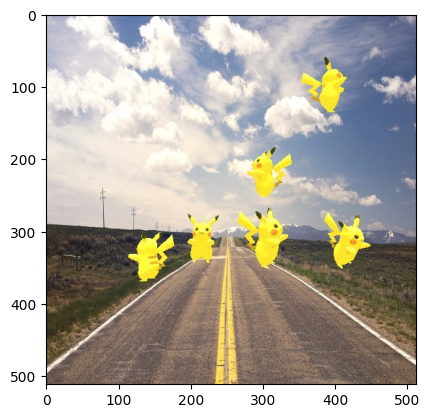

In [8]:
!test -f pikachu.jpg || wget https://raw.githubusercontent.com/d2l-ai/d2l-en/master/img/pikachu.jpg
img = plt.imread('pikachu.jpg')
plt.imshow(img);

In [104]:
pikachu_bboxes = [[100.0, 300.0, 180.0, 380.0], 
                  [180.0, 270.0, 250.0, 350.0],
                  [250.0, 260.0, 350.0, 350.0],
                  [270.0, 180.0, 350.0, 250.0],
                  [350.0, 50.0, 430.0, 150.0],
                  [380.0, 270.0, 450.0, 350.0]]

boxes = torch.tensor(pikachu_bboxes)

boxes.shape

torch.Size([6, 4])

In [105]:
box_center_to_corner(box_corner_to_center(boxes)) == boxes

tensor([[True, True, True, True],
        [True, True, True, True],
        [True, True, True, True],
        [True, True, True, True],
        [True, True, True, True],
        [True, True, True, True]])

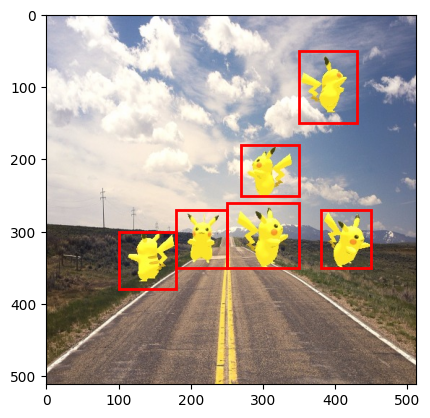

In [106]:
fig = plt.imshow(img)
for i in range(np.array(pikachu_bboxes).shape[0]) :
    if i > 5 :
        break
    fig.axes.add_patch(bbox_to_rect(pikachu_bboxes[i], 'red'))
plt.imshow(img);

### Questions

> For each of these tasks: classification, localization, and detection, how many bounding boxes can be predicted for each input image?

> How many scalar values are necessary to describe a bounding box?

*Your answers here*